# Read in student choices and create a dictionary corresponding to the score of each choice

In [5]:
import pandas as pd
import numpy as np
import random
import numpy.random as npr
import matplotlib.pyplot as plt

students = pd.read_csv('Student-choices.csv')

student_scores = {}

for index, row in students.iterrows():
    student_scores[str(index+1)] = {}
    for i in range(22):
        i=i+1
        student_scores[str(index+1)][str(row[str(i)])] = i



# Read in supervisor availability, creating a list of supervisors. If a supervisor has a capacity of n, they will appear n  in this list

In [6]:
supervisors = pd.read_csv('Supervisors.csv')

sv = []
for index, row in supervisors.iterrows():
    
    num = row['Supervisors'].split('_')[-1]
    capacity = int(row['Capacity'])
    for i in range(capacity):        
        sv.append(num)
sv = np.array(sv)


# Functions

In [29]:
def generate_random_sample(length):    
    sample = []    
    numbers = np.random.choice(sv, length, replace=False) 
    for i in range(length):
        sample.append([str(i+1), numbers[i]])
    sample = np.array(sample)
    return sample

# There are 2 fitness functions, evaluate_fitness is used for evolving the population, the higher the score the better
# the actual fitness function is the inverse of the previous function. The lower the score the better. 
# The actual fitness fucntion will be used for interpreting results and plotting the graph of fitness

def evaluate_fitness(sample):
    score = 0
    for x in sample:
        
        s = student_scores[x[0]][x[1]]
        
        s= 23-s
        score = score+s        
    return score

def evaluate_actual_fitness(sample):
    score = 0
    for x in sample:
        s = student_scores[x[0]][x[1]]        
        score = score+s        
    return score

#swap 2 students supervisors
def mutate(sample, length):
    # if all supervisors are used we can swap
    sample = sample.copy()
    if len(sv) == length:
        index1 = random.randint(0, len(sample) - 1)
        index2 = random.randint(0, len(sample) - 1)
        sample[index1][1] = sample[index2][1]
        sample[index2][1] = sample[index1][1]
        return sample
    
    # otherwise swapping may result in some supervisors not getting looked at
    # find supervisors not being used and replace supervisor with one student
    else:
        svs_used = []
        for x in sample:
            svs_used.append(x[1])
        svs_remaining = [item for item in sv if item not in svs_used]
        
       
        random_sv = svs_remaining[random.randint(0, len(svs_remaining) - 1)]
        index = random.randint(0, len(sample) - 1)
        sample[index][1] = random_sv
        return sample
    
    
# cross over function:
# child is randomly assigned different mappings from different parents
# it gets quite complex to make sure all supervisors are not overbooked
        
def crossover(parent1, parent2, length):
    # indexs represent a random ordering of the first #length students
    indexs = np.random.choice(range(length), length, replace=False)
    
    mapping = [] #new combination of mappings created from the 2 parents
    for index in indexs: 
        x=random.randint(0, 1) # 50-50 chance each student gets the lecturer assigned to for each parent
        if x == 0:
            p1_sample = parent1[index]
            mapping.append(p1_sample)
            
        else:
            p2_sample = parent2[index]
            mapping.append(p2_sample)
    
    # now we have mappings but some lecturers may be overloaded with students
    # to fix this we will assign some of the students random available lecturers
    svs_available = sv.copy()
    unavailable_instances = []
    
    mapping = np.array(mapping)
    for i in range(len(mapping)):
        if mapping[i][1] in svs_available: #if the lectuter is free for that student remove from the list
            svs_available = np.delete(svs_available, np.where(svs_available==mapping[i][1])[0][0])
            
        elif parent1[indexs[i]][1] in svs_available and parent1[indexs[i]][1] != mapping[i][1]:    
                       
            svs_available = np.delete(svs_available, np.where(svs_available==parent1[indexs[i]][1])[0][0])
            mapping[i] = parent1[[indexs[i]]]
                        
        elif parent2[indexs[i]][1] in svs_available and parent2[indexs[i]][1] != mapping[i][1]: 
            
            svs_available = np.delete(svs_available, np.where(svs_available==parent2[indexs[i]][1])[0][0])
            mapping[i] = parent2[[indexs[i]]]
            
        else:
            unavailable_instances.append(i)
    for i in unavailable_instances:
        
        available_supervisor = np.random.choice(svs_available)
        mapping[i][1] = available_supervisor
        svs_available = np.delete(svs_available, np.where(svs_available==available_supervisor)[0][0])
        
    # ------ this part is just me awkwardly trying to order the sample 
    mapping_list = mapping.copy().tolist() 
    
    for i in range(len(mapping_list)):
        mapping_list[i][0] = int(mapping_list[i][0])
    
    mapping_list = sorted(mapping_list,key=lambda x: (x[0],x[1]))
    for i in range(len(mapping_list)):
        mapping_list[i][0] = str(mapping_list[i][0])
        
    return np.array(mapping_list)
    
    

def select_parent_roulette(population, fitness_values):    
    
    maximum = sum(fitness_values)    
    selection_probs = [x/maximum for x in fitness_values]
    return population[npr.choice(len(population), p=selection_probs)]

def select_best_parent(population, fitness_values):
    
    fitness_values = np.array(fitness_values)
    return population[fitness_values.argmax()]



# Test on small dataset first

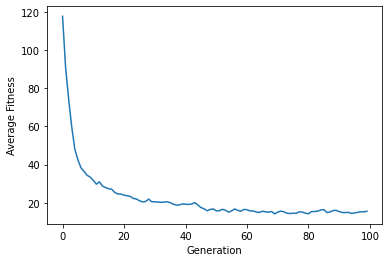

In [13]:
def genetic_algorithm(population_size, length, generations, mutation_rate):
    population = [generate_random_sample(length) for _ in range(population_size)]
    fitness_values = [evaluate_fitness(sample) for sample in population]
    actual_fitness_values = [evaluate_actual_fitness(sample) for sample in population]
    
    average_fitness = []
    average_actual_fitness = []
    
    for generation in range(generations):
        #print(generation)
        average_fitness.append(sum(fitness_values) / len(fitness_values))
        average_actual_fitness.append(sum(actual_fitness_values) / len(actual_fitness_values))
        new_population = []
        while len(new_population) < population_size:
            parent1 = select_parent_roulette(population, fitness_values)
            parent2 = select_best_parent(population, fitness_values)
            child = crossover(parent1, parent2, length)
            if random.random() < mutation_rate:
                child = mutate(child, length)
            
                
            new_population.append(child)
        
        population = new_population
        fitness_values = [evaluate_fitness(sample) for sample in population]
        actual_fitness_values = [evaluate_actual_fitness(sample) for sample in population]
    return average_actual_fitness

population_size = 100
length = 10 #FIRST 10 students
generations = 100

mutation_rate = 0.1

average_fitness = genetic_algorithm(population_size, length, generations, mutation_rate)

plt.plot(average_fitness)
plt.xlabel("Generation")
plt.ylabel("Average Fitness")
plt.show()


A best average score of  under 20 (roughly 15) would indicate on average each student got their 1.5th preference, or a student either got their first or second preference on average

# Test on full dataset,  both parents selected roulette (too noisy)


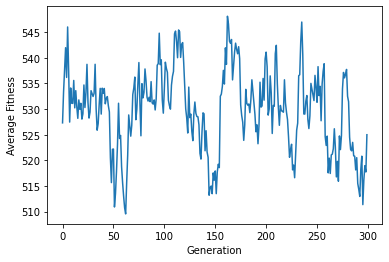

In [21]:
def genetic_algorithm(population_size, length, generations, mutation_rate):
    population = [generate_random_sample(length) for _ in range(population_size)]
    fitness_values = [evaluate_fitness(sample) for sample in population]
    actual_fitness_values = [evaluate_actual_fitness(sample) for sample in population]
    
    average_fitness = []
    average_actual_fitness = []
    
    for generation in range(generations):
        #print(generation)
        average_fitness.append(sum(fitness_values) / len(fitness_values))
        average_actual_fitness.append(sum(actual_fitness_values) / len(actual_fitness_values))
        new_population = []
        while len(new_population) < population_size:
            parent1 = select_parent_roulette(population, fitness_values)
            parent2 = select_parent_roulette(population, fitness_values)
            child = crossover(parent1, parent2, length)
            if random.random() < mutation_rate:
                child = mutate(child, length)
            
                
            new_population.append(child)
        
        population = new_population
        fitness_values = [evaluate_fitness(sample) for sample in population]
        actual_fitness_values = [evaluate_actual_fitness(sample) for sample in population]
    return average_actual_fitness

population_size = 100
length = 46 #all students
generations = 300

mutation_rate = 0.1

average_fitness = genetic_algorithm(population_size, length, generations, mutation_rate)

plt.plot(average_fitness)
plt.xlabel("Generation")
plt.ylabel("Average Fitness")
plt.show()


choosing both parents by roulette is not optimal

# Test on full dataset only picking the best parent, no crossover (not enough variation)

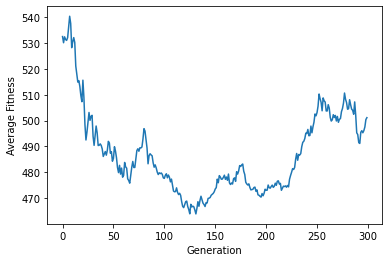

In [28]:
def genetic_algorithm(population_size, length, generations, mutation_rate):
    population = [generate_random_sample(length) for _ in range(population_size)]
    fitness_values = [evaluate_fitness(sample) for sample in population]
    actual_fitness_values = [evaluate_actual_fitness(sample) for sample in population]
    
    average_fitness = []
    average_actual_fitness = []
    
    for generation in range(generations):
        #print(generation)
        average_fitness.append(sum(fitness_values) / len(fitness_values))
        average_actual_fitness.append(sum(actual_fitness_values) / len(actual_fitness_values))
        new_population = []
        while len(new_population) < population_size:
            child = select_parent_roulette(population, fitness_values)
            
            
            if random.random() < mutation_rate:
                child = mutate(child, length)
            
                
            new_population.append(child)
        
        population = new_population
        fitness_values = [evaluate_fitness(sample) for sample in population]
        actual_fitness_values = [evaluate_actual_fitness(sample) for sample in population]
    return average_actual_fitness

population_size = 100
length = 46 #all students
generations = 300

mutation_rate = 0.1

average_fitness = genetic_algorithm(population_size, length, generations, mutation_rate)

plt.plot(average_fitness)
plt.xlabel("Generation")
plt.ylabel("Average Fitness")
plt.show()


Not enough variation to achieve good results

# Test on full dataset (best parent and roulette parent crossover)

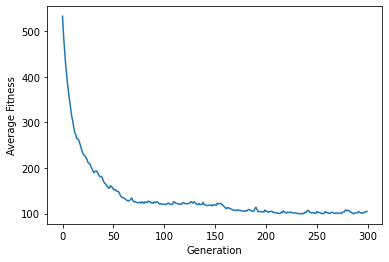

In [31]:
def genetic_algorithm(population_size, length, generations, mutation_rate):
    population = [generate_random_sample(length) for _ in range(population_size)]
    fitness_values = [evaluate_fitness(sample) for sample in population]
    actual_fitness_values = [evaluate_actual_fitness(sample) for sample in population]
    
    average_fitness = []
    average_actual_fitness = []
    
    for generation in range(generations):
        #print(generation)
        average_fitness.append(sum(fitness_values) / len(fitness_values))
        average_actual_fitness.append(sum(actual_fitness_values) / len(actual_fitness_values))
        new_population = []
        while len(new_population) < population_size:
            parent1 = select_parent_roulette(population, fitness_values)
            parent2 = select_best_parent(population, fitness_values)
            child = crossover(parent1, parent2, length)
            if random.random() < mutation_rate:
                child = mutate(child, length)
            
                
            new_population.append(child)
        
        population = new_population
        fitness_values = [evaluate_fitness(sample) for sample in population]
        actual_fitness_values = [evaluate_actual_fitness(sample) for sample in population]
    return average_actual_fitness

population_size = 100
length = 46 #all students
generations = 300

mutation_rate = 0.1

average_fitness = genetic_algorithm(population_size, length, generations, mutation_rate)

plt.plot(average_fitness)
plt.xlabel("Generation")
plt.ylabel("Average Fitness")
plt.show()


In [27]:
average_preference = 100/46
average_preference

2.1739130434782608

Every student gets just over their 2nd preference on average after 300 generations of evolution